# The Efficient Frontier 

###  The magic of diversification due to correlation
In modern portfolio theory, the efficient frontier (or portfolio frontier) is a combination of assets, i.e. a portfolio, is referred to as "efficient" if it has the best possible expected level of return for its level of risk (which is represented by the standard deviation of the portfolio's return). Here, every possible combination of risky assets can be plotted in risk–expected return space, and the collection of all such possible portfolios defines a region in this space. The positively sloped (upward-sloped) top boundary of this region is a portion of a hyperbola and is called the "efficient frontier".

If a risk-free asset is also available, the opportunity set is larger, and its upper boundary, the efficient frontier, is a straight line segment emanating from the vertical axis at the value of the risk-free asset's return and tangent to the risky-assets-only opportunity set. All portfolios between the risk-free asset and the tangency portfolio are portfolios composed of risk-free assets and the tangency portfolio, while all portfolios on the linear frontier above and to the right of the tangency portfolio are generated by borrowing at the risk-free rate and investing the proceeds into the tangency portfolio.

The efficient frontier rates portfolios (investments) on a scale of return (y-axis) versus risk (x-axis). Compound Annual Growth Rate (CAGR) of an investment is commonly used as the return component while standard deviation (annualized) depicts the risk metric. 

In this exercise, we are going to learn how to compute the efficient frontier when we have a set of expected returns, volatilities (or variances) and correlations (or covariances). It's a fair question as to how we can get these numbers for the future, but for now, we'll assume that historic returns are a reasonable estimate. In future sections, we'll learn how to improve on it.

<img src="https://raw.githubusercontent.com/safarini/Pictures/master/CME-Efficient-Frontier_02.png" align="center" width="500" ></center>

The only free lunch in all of finance is basically this, that if you take two decorrelated assets and you put them together, you can construct a portfolio that has a lower volatility.

<img src="https://raw.githubusercontent.com/safarini/Pictures/master/CME-Efficient-Frontier.jpg" align="center" ></center>

In [145]:
import pandas as pd
import numpy  as np
from scipy.stats    import norm
from scipy.stats    import skew
from scipy.stats    import kurtosis
from scipy.optimize import minimize
import numpy.ma as ma

csv_file = 'https://raw.githubusercontent.com/safarini/GSF/master/003_ind30_m_vw_rets.csv'
ind = pd.read_csv(csv_file, header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [2]:
ind.head()

,Stock_01,Stock_02,Stock_03,Stock_04,Stock_05,Stock_06,Stock_07,Stock_08,Stock_09,Stock_10,...,Stock_21,Stock_22,Stock_23,Stock_24,Stock_25,Stock_26,Stock_27,Stock_28,Stock_29,Stock_30
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


This dataset goes back to 1926 up to present day and It is the monthly returns of 30 different stocks across multiple industries.

In [3]:
ind.head()

,Stock_01,Stock_02,Stock_03,Stock_04,Stock_05,Stock_06,Stock_07,Stock_08,Stock_09,Stock_10,...,Stock_21,Stock_22,Stock_23,Stock_24,Stock_25,Stock_26,Stock_27,Stock_28,Stock_29,Stock_30
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [4]:
ind.columns

Index(['Stock_01 ', 'Stock_02', 'Stock_03', 'Stock_04', 'Stock_05', 'Stock_06',
       'Stock_07', 'Stock_08', 'Stock_09', 'Stock_10', 'Stock_11', 'Stock_12',
       'Stock_13', 'Stock_14', 'Stock_15', 'Stock_16', 'Stock_17', 'Stock_18',
       'Stock_19', 'Stock_20', 'Stock_21', 'Stock_22', 'Stock_23', 'Stock_24',
       'Stock_25', 'Stock_26', 'Stock_27', 'Stock_28', 'Stock_29', 'Stock_30'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the `.str.strip` method.

In [5]:
ind.columns = ind.columns.str.strip()

In [6]:
ind.columns

Index(['Stock_01', 'Stock_02', 'Stock_03', 'Stock_04', 'Stock_05', 'Stock_06',
       'Stock_07', 'Stock_08', 'Stock_09', 'Stock_10', 'Stock_11', 'Stock_12',
       'Stock_13', 'Stock_14', 'Stock_15', 'Stock_16', 'Stock_17', 'Stock_18',
       'Stock_19', 'Stock_20', 'Stock_21', 'Stock_22', 'Stock_23', 'Stock_24',
       'Stock_25', 'Stock_26', 'Stock_27', 'Stock_28', 'Stock_29', 'Stock_30'],
      dtype='object')

In [7]:
ind.shape

(1110, 30)

Now, so let's add the following code to our module for future use.

In [8]:
def get_ind_returns():
    """
    Load and format the 30 stocks monthly returns
    """
    csv_file = 'https://raw.githubusercontent.com/safarini/GSF/master/003_ind30_m_vw_rets.csv'
    ind = pd.read_csv(csv_file, header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    return ind

To calculate the drawdown, we can apply the following function 

In [9]:
# pd.Series is a column in the DataFrame, : pd.Series is not needed but its good practice to do it, so python knows that its a series
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for the wealth index, 
       the previous peaks, and the percentage drawdown """
    
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [10]:
wealth_index = (1+ind['Stock_01']).cumprod()
wealth_index

1926-07        1.005600
1926-08        1.031645
1926-09        1.043612
1926-10        1.011678
1926-11        1.075919
               ...     
2018-08    12609.751105
2018-09    12569.399902
2018-10    12697.607781
2018-11    13042.982713
2018-12    11773.900495
Freq: M, Name: Stock_01, Length: 1110, dtype: float64

In [11]:
previous_peaks = wealth_index.cummax()
previous_peaks

1926-07        1.005600
1926-08        1.031645
1926-09        1.043612
1926-10        1.043612
1926-11        1.075919
               ...     
2018-08    13161.035989
2018-09    13161.035989
2018-10    13161.035989
2018-11    13161.035989
2018-12    13161.035989
Freq: M, Name: Stock_01, Length: 1110, dtype: float64

In [12]:
drawdowns = (wealth_index - previous_peaks)/previous_peaks
drawdowns

1926-07    0.000000
1926-08    0.000000
1926-09    0.000000
1926-10   -0.030600
1926-11    0.000000
             ...   
2018-08   -0.041888
2018-09   -0.044954
2018-10   -0.035212
2018-11   -0.008970
2018-12   -0.105397
Freq: M, Name: Stock_01, Length: 1110, dtype: float64

In [13]:
drawdown(ind['Stock_01'])

,Wealth,Previous Peak,Drawdown
1926-07,1.005600e+03,1.005600e+03,0.000000
1926-08,1.031645e+03,1.031645e+03,0.000000
1926-09,1.043612e+03,1.043612e+03,0.000000
1926-10,1.011678e+03,1.043612e+03,-0.030600
1926-11,1.075919e+03,1.075919e+03,0.000000
...,...,...,...
2018-08,1.260975e+07,1.316104e+07,-0.041888
2018-09,1.256940e+07,1.316104e+07,-0.044954
2018-10,1.269761e+07,1.316104e+07,-0.035212
2018-11,1.304298e+07,1.316104e+07,-0.008970


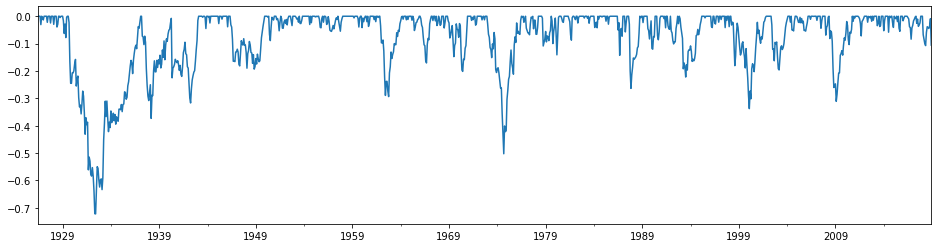

In [14]:
drawdown(ind['Stock_01'])["Drawdown"].plot.line(figsize = (16,4))

To calculate the var_gaussian, we can apply the following function

norm: ppf(q, loc=0, scale=1) Percent point function (inverse of cdf — percentiles). Returns a 95% significance interval for a one-tail test on a standard normal distribution (i.e. a special case of the normal distribution where the mean is 0 and the standard deviation is 1)

<img src="https://raw.githubusercontent.com/safarini/Pictures/master/The_Normal_Distributionv2.svg.png" align="center" width="800" ></center>

In [15]:
# the z score
z = norm.ppf(0.05)
z

-1.6448536269514729

In [16]:
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skew(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [17]:
var_gaussian(ind[["Stock_01", "Stock_02", "Stock_03"]], modified=True)

Stock_01    0.064071
Stock_02    0.038229
Stock_03    0.083807
dtype: float64

In [18]:
var_gaussian(ind[["Stock_01", "Stock_02", "Stock_03"]], modified=False)

Stock_01    0.068226
Stock_02    0.106206
Stock_03    0.084150
dtype: float64

In [19]:
# Sort the stocks by Value at Risk 
var_gaussian(ind, modified=True).sort_values()

Stock_02    0.038229
Stock_18    0.053891
Stock_01    0.064071
Stock_21    0.067497
Stock_06    0.068396
Stock_25    0.069747
Stock_22    0.071143
Stock_15    0.074349
Stock_20    0.074914
Stock_08    0.075250
Stock_24    0.076727
Stock_29    0.079301
Stock_12    0.079537
Stock_09    0.083070
Stock_07    0.083388
Stock_03    0.083807
Stock_27    0.084048
Stock_10    0.084166
Stock_19    0.084932
Stock_26    0.085028
Stock_30    0.091360
Stock_14    0.092212
Stock_13    0.092854
Stock_05    0.093005
Stock_11    0.093829
Stock_16    0.099108
Stock_28    0.102316
Stock_23    0.103463
Stock_04    0.106097
Stock_17    0.107190
dtype: float64

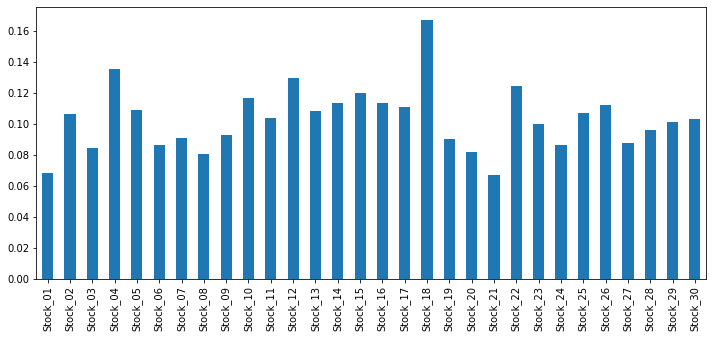

In [115]:
var_gaussian(ind).plot.bar(figsize=(12,5))

Let's use this as an opportunity to write functions for annualized returns, volatility and sharpe ratios.

Annualized Return

In [21]:
def annualize_rets(r, periods_per_year):
    """
    r is a series of return
    Annualizes a set of returns We should infer the periods per year
    but that is currently left for later. 
    """
    compounded_growth = (1+r).prod()
    # Get the length of the series
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [22]:
annualize_rets(ind, 12).sort_values()

Stock_18    0.062543
Stock_26    0.067420
Stock_12    0.067926
Stock_30    0.068767
Stock_17    0.075994
Stock_05    0.079147
Stock_10    0.083356
Stock_25    0.084093
Stock_11    0.086209
Stock_20    0.090147
Stock_04    0.091829
Stock_21    0.092669
Stock_06    0.093513
Stock_07    0.093518
Stock_15    0.094397
Stock_13    0.098153
Stock_29    0.098169
Stock_19    0.101700
Stock_24    0.106115
Stock_28    0.106644
Stock_01    0.106649
Stock_16    0.107120
Stock_09    0.107320
Stock_27    0.107438
Stock_14    0.109179
Stock_22    0.109196
Stock_23    0.112490
Stock_08    0.116723
Stock_02    0.120041
Stock_03    0.122324
dtype: float64

Annualized Volatility

In [23]:
def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left for later
    """
    return r.std()*(periods_per_year**0.5)

In [24]:
annualize_vol(ind, 12).sort_values()

Stock_21    0.159056
Stock_01    0.163974
Stock_20    0.190571
Stock_08    0.192703
Stock_06    0.200962
Stock_03    0.201206
Stock_24    0.202983
Stock_27    0.206729
Stock_07    0.210732
Stock_19    0.211075
Stock_09    0.218022
Stock_28    0.224011
Stock_23    0.233885
Stock_30    0.234123
Stock_29    0.234825
Stock_11    0.238219
Stock_25    0.244961
Stock_05    0.247850
Stock_02    0.248922
Stock_13    0.249735
Stock_17    0.252297
Stock_26    0.253232
Stock_16    0.262226
Stock_14    0.262667
Stock_10    0.265996
Stock_15    0.275035
Stock_22    0.288004
Stock_12    0.292022
Stock_04    0.308881
Stock_18    0.373938
dtype: float64

Sharpe ratio

The Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment.

In [25]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

In [26]:
sharpe_ratio(ind, 0.03, 12).sort_values()

Stock_18    0.084275
Stock_12    0.126052
Stock_26    0.143494
Stock_30    0.160862
Stock_17    0.177109
Stock_05    0.192686
Stock_04    0.194420
Stock_10    0.194906
Stock_25    0.214624
Stock_15    0.227548
Stock_11    0.229351
Stock_13    0.265297
Stock_22    0.267263
Stock_29    0.282243
Stock_16    0.285916
Stock_14    0.293063
Stock_07    0.293105
Stock_20    0.306945
Stock_06    0.307349
Stock_19    0.330358
Stock_28    0.332717
Stock_23    0.342974
Stock_09    0.344903
Stock_02    0.351780
Stock_27    0.364325
Stock_24    0.364722
Stock_21    0.383294
Stock_08    0.437783
Stock_03    0.446361
Stock_01    0.454770
dtype: float64

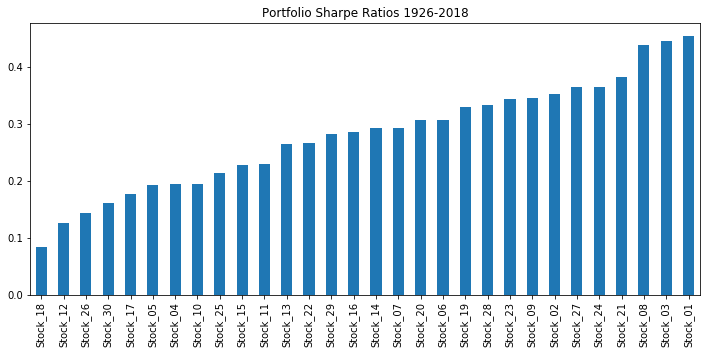

In [27]:
sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Portfolio Sharpe Ratios 1926-2018", figsize=(12,5))

Since 1926 stock 01 has the best unit of return per unit of risk.  
We can change the period to make it from 2010

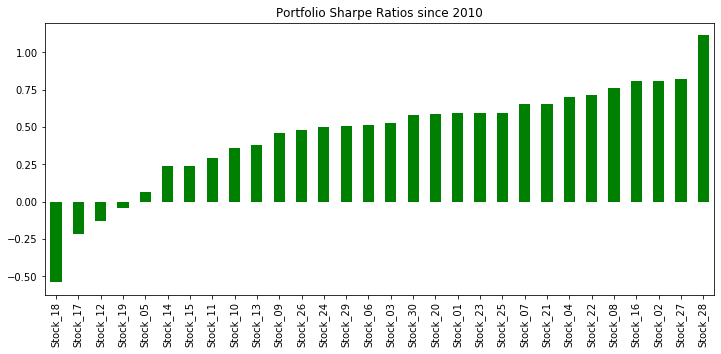

In [28]:
sharpe_ratio(ind["2010":], 0.03, 12).sort_values().plot.bar(title='Portfolio Sharpe Ratios since 2010', color = 'green', figsize=(12,5))

Since 2010 stock 28 has the best unit of return per unit of risk.

## Expected Returns and the Covariance Matrix

Generating the efficient frontier requires a set of expected returns and a covariance matrix. For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. Clearly, they will not, but we will have plenty of time to dig into that later. For the moment, assume that our naive method of estimating these parameters will suffice.

We can generate an estimate of expected returns using the `annualize_rets()` function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [29]:
er = annualize_rets(ind["1996":"2000"], 12)
er

Stock_01    0.116799
Stock_02    0.141126
Stock_03    0.107830
Stock_04    0.068212
Stock_05    0.187286
Stock_06    0.134766
Stock_07    0.079160
Stock_08    0.246641
Stock_09    0.077456
Stock_10   -0.042721
Stock_11    0.084076
Stock_12    0.115809
Stock_13    0.108280
Stock_14    0.272420
Stock_15    0.080954
Stock_16    0.173904
Stock_17   -0.053554
Stock_18    0.414689
Stock_19    0.165377
Stock_20    0.145903
Stock_21    0.122771
Stock_22    0.175264
Stock_23    0.271952
Stock_24    0.097163
Stock_25    0.071099
Stock_26    0.126431
Stock_27    0.207247
Stock_28    0.067400
Stock_29    0.223371
Stock_30    0.043349
dtype: float64

In [30]:
er.shape

(30,)

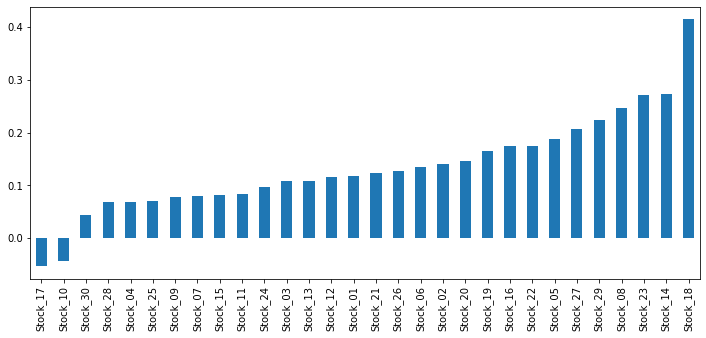

In [31]:
er.sort_values().plot.bar(figsize=(12,5))

Let's generate the correlation matrix using the `.corr()` method:

In [32]:
corr_df = ind["1996":"2000"].corr()
corr_df.style.background_gradient(cmap='coolwarm')

,Stock_01,Stock_02,Stock_03,Stock_04,Stock_05,Stock_06,Stock_07,Stock_08,Stock_09,Stock_10,Stock_11,Stock_12,Stock_13,Stock_14,Stock_15,Stock_16,Stock_17,Stock_18,Stock_19,Stock_20,Stock_21,Stock_22,Stock_23,Stock_24,Stock_25,Stock_26,Stock_27,Stock_28,Stock_29,Stock_30
Stock_01,1.000000,0.641929,0.441533,0.269702,0.396582,0.468152,0.451062,0.475349,0.483514,0.426239,0.481803,0.016186,0.220085,0.372068,0.184053,0.482837,0.207350,0.003822,0.374922,0.413887,0.218641,0.053184,-0.062861,0.479001,0.562270,0.277020,0.452205,0.441031,0.661424,0.319407
Stock_02,0.641929,1.000000,0.204952,0.302418,0.233257,0.672693,0.312278,0.531984,0.351559,0.495032,0.517328,0.034476,0.160606,0.246517,0.318773,0.432720,0.044633,0.174441,0.179403,0.198724,0.264425,0.069167,0.000985,0.403747,0.589620,0.183633,0.394918,0.460009,0.561547,0.294224
Stock_03,0.441533,0.204952,1.000000,0.067583,-0.027358,0.222367,0.138226,0.224305,0.163203,0.152684,0.261938,0.041461,0.151256,0.000972,0.052203,0.308898,0.202465,-0.058735,0.191244,0.312555,0.011417,-0.027390,-0.013434,0.248660,0.081208,0.357271,0.019543,0.141022,0.227552,0.294024
Stock_04,0.269702,0.302418,0.067583,1.000000,0.549992,0.341731,0.473872,0.460497,0.504999,0.414654,0.542392,0.599744,0.702468,0.562202,0.587218,0.475353,0.337092,0.225148,0.323537,0.013152,0.523757,0.531447,0.570015,0.516486,0.481102,0.612054,0.516504,0.465616,0.623332,0.598378
Stock_05,0.396582,0.233257,-0.027358,0.549992,1.000000,0.349193,0.614260,0.292747,0.591686,0.511486,0.567632,0.458298,0.577264,0.687031,0.512777,0.433448,0.297179,0.347648,0.343326,0.241216,0.628164,0.530809,0.387858,0.548800,0.650858,0.520876,0.737179,0.426323,0.701003,0.435344
Stock_06,0.468152,0.672693,0.222367,0.341731,0.349193,1.000000,0.305550,0.506362,0.429875,0.425368,0.599193,0.265268,0.354177,0.422009,0.466223,0.535609,0.139389,0.293240,0.191780,0.145536,0.308929,0.261331,0.195549,0.558539,0.515843,0.227519,0.406744,0.383485,0.527471,0.424444
Stock_07,0.451062,0.312278,0.138226,0.473872,0.614260,0.305550,1.000000,0.218901,0.681172,0.588767,0.646361,0.296372,0.571045,0.499047,0.584075,0.683921,0.416004,0.271971,0.454379,0.238601,0.319590,0.247700,0.113144,0.720921,0.712819,0.491845,0.679147,0.662991,0.676545,0.471789
Stock_08,0.475349,0.531984,0.224305,0.460497,0.292747,0.506362,0.218901,1.000000,0.163674,0.215078,0.457044,0.236580,0.268107,0.359925,0.306048,0.241166,0.281365,0.275045,0.209423,0.253402,0.398013,0.373680,0.308976,0.219927,0.349227,0.398593,0.290952,0.356703,0.506138,0.383382
Stock_09,0.483514,0.351559,0.163203,0.504999,0.591686,0.429875,0.681172,0.163674,1.000000,0.584507,0.603763,0.531685,0.671396,0.443768,0.540557,0.705509,0.493508,0.283239,0.644258,0.263596,0.293720,0.240823,0.183655,0.873774,0.718587,0.468946,0.535342,0.526905,0.683591,0.555010
Stock_10,0.426239,0.495032,0.152684,0.414654,0.511486,0.425368,0.588767,0.215078,0.584507,1.000000,0.551412,0.278517,0.458911,0.316771,0.539997,0.567897,0.269376,0.096090,0.405020,0.372016,0.271828,0.136694,0.128180,0.631461,0.646889,0.551486,0.548184,0.410199,0.563697,0.500574


Let's generate the covariance matrix using the `.cov` method:

In [33]:
cov_df = ind["1996":"2000"].cov()
cov_df.style.background_gradient(cmap='coolwarm')

,Stock_01,Stock_02,Stock_03,Stock_04,Stock_05,Stock_06,Stock_07,Stock_08,Stock_09,Stock_10,Stock_11,Stock_12,Stock_13,Stock_14,Stock_15,Stock_16,Stock_17,Stock_18,Stock_19,Stock_20,Stock_21,Stock_22,Stock_23,Stock_24,Stock_25,Stock_26,Stock_27,Stock_28,Stock_29,Stock_30
Stock_01,0.002609,0.002379,0.002061,0.000846,0.001035,0.001374,0.001733,0.001230,0.001414,0.001216,0.001487,0.000070,0.000742,0.001313,0.000618,0.001583,0.000909,0.000027,0.001079,0.000943,0.000667,0.000237,-0.000315,0.001429,0.001534,0.000740,0.001363,0.001230,0.002132,0.001057
Stock_02,0.002379,0.005264,0.001359,0.001348,0.000865,0.002804,0.001704,0.001955,0.001460,0.002005,0.002268,0.000213,0.000769,0.001236,0.001520,0.002015,0.000278,0.001728,0.000733,0.000643,0.001146,0.000438,0.000007,0.001710,0.002284,0.000697,0.001690,0.001822,0.002571,0.001383
Stock_03,0.002061,0.001359,0.008349,0.000379,-0.000128,0.001167,0.000950,0.001038,0.000853,0.000779,0.001446,0.000322,0.000912,0.000006,0.000314,0.001812,0.001588,-0.000733,0.000984,0.001274,0.000062,-0.000218,-0.000120,0.001327,0.000396,0.001707,0.000105,0.000703,0.001312,0.001741
Stock_04,0.000846,0.001348,0.000379,0.003773,0.001726,0.001206,0.002189,0.001433,0.001775,0.001422,0.002013,0.003132,0.002848,0.002386,0.002371,0.001874,0.001777,0.001888,0.001119,0.000036,0.001922,0.002848,0.003434,0.001852,0.001578,0.001966,0.001872,0.001561,0.002416,0.002382
Stock_05,0.001035,0.000865,-0.000128,0.001726,0.002612,0.001025,0.002361,0.000758,0.001731,0.001459,0.001753,0.001992,0.001947,0.002426,0.001723,0.001422,0.001304,0.002426,0.000988,0.000550,0.001918,0.002367,0.001944,0.001638,0.001776,0.001392,0.002223,0.001189,0.002261,0.001442
Stock_06,0.001374,0.002804,0.001167,0.001206,0.001025,0.003300,0.001320,0.001473,0.001413,0.001364,0.002080,0.001296,0.001343,0.001675,0.001760,0.001975,0.000687,0.002300,0.000620,0.000373,0.001060,0.001310,0.001102,0.001873,0.001582,0.000683,0.001378,0.001202,0.001912,0.001580
Stock_07,0.001733,0.001704,0.000950,0.002189,0.002361,0.001320,0.005655,0.000834,0.002932,0.002472,0.002937,0.001895,0.002834,0.002593,0.002887,0.003301,0.002685,0.002792,0.001924,0.000800,0.001436,0.001625,0.000834,0.003165,0.002862,0.001934,0.003013,0.002721,0.003210,0.002299
Stock_08,0.001230,0.001955,0.001038,0.001433,0.000758,0.001473,0.000834,0.002565,0.000474,0.000608,0.001399,0.001019,0.000896,0.001260,0.001019,0.000784,0.001223,0.001902,0.000597,0.000572,0.001204,0.001651,0.001535,0.000650,0.000944,0.001056,0.000869,0.000986,0.001617,0.001258
Stock_09,0.001414,0.001460,0.000853,0.001775,0.001731,0.001413,0.002932,0.000474,0.003276,0.001868,0.002088,0.002588,0.002536,0.001755,0.002034,0.002592,0.002425,0.002213,0.002077,0.000673,0.001004,0.001203,0.001031,0.002920,0.002196,0.001404,0.001808,0.001646,0.002469,0.002059
Stock_10,0.001216,0.002005,0.000779,0.001422,0.001459,0.001364,0.002472,0.000608,0.001868,0.003117,0.001860,0.001322,0.001691,0.001222,0.001982,0.002035,0.001291,0.000732,0.001274,0.000926,0.000907,0.000666,0.000702,0.002058,0.001929,0.001610,0.001805,0.001250,0.001986,0.001811


We can make this a triangle as well to remove the duplicate   

In [34]:
# .tril() upper and triu() lower 
mask_ut=np.triu(np.ones(corr_df.shape),1).astype(np.bool)
mask_ut

array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False,

In [35]:
mask_ut_df = pd.DataFrame(mask_ut)
mask_ut_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [36]:
corr_df = corr_df.mask(mask_ut)
corr_df.style.background_gradient(cmap='coolwarm')

C:\Users\SADEQ\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,Stock_01,Stock_02,Stock_03,Stock_04,Stock_05,Stock_06,Stock_07,Stock_08,Stock_09,Stock_10,Stock_11,Stock_12,Stock_13,Stock_14,Stock_15,Stock_16,Stock_17,Stock_18,Stock_19,Stock_20,Stock_21,Stock_22,Stock_23,Stock_24,Stock_25,Stock_26,Stock_27,Stock_28,Stock_29,Stock_30
Stock_01,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_02,0.641929,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_03,0.441533,0.204952,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_04,0.269702,0.302418,0.067583,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_05,0.396582,0.233257,-0.027358,0.549992,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_06,0.468152,0.672693,0.222367,0.341731,0.349193,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_07,0.451062,0.312278,0.138226,0.473872,0.614260,0.305550,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_08,0.475349,0.531984,0.224305,0.460497,0.292747,0.506362,0.218901,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_09,0.483514,0.351559,0.163203,0.504999,0.591686,0.429875,0.681172,0.163674,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stock_10,0.426239,0.495032,0.152684,0.414654,0.511486,0.425368,0.588767,0.215078,0.584507,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [37]:
corr_df.shape

(30, 30)

Note:   
1- The correlations between the assets in a portfolio only affect the volatility of the portfolio, not the returns of the portfolio.  
2- The portfolio volatility is a function of the covariances between each pair of assets, which in turn depends on the volatilities and correlations of the assets.  
3- The Covariance Matrix is a symmetric matrix with variances along the diagonal and the product of the pairwise correlation and the individual volatililites (i.e. the covariance) on the off-diagonal entries

Now, we'll take the expected returns vector and the covariance matrix we've constructed and start to plot the efficient frontier!  

As a first exercise, let's assume we have some weights, and let's try and compute the returns and volatility of a portfolio, given a set of weights, returns, and a covariance matrix.

Let's start by loading the returns and generating the expected returns vector and the covariance matrix

<img src="https://www.wallstreetmojo.com/wp-content/uploads/2019/01/Expected-Return-formula-1.jpg" align="center" width="500" ></center>

In [38]:
# Every stock should have one expected return and one weight
# We have 30 stocks, therefore the weights matrix will be [30,1] 

# To multiply 2 matrices the number of columns of the first matrix should match the number of rows from the second matrix
# weights matrix before transpose [30:1]
# weights matrix after transpose [1:30]
# return matrix [30:1]
# multiply  [1:30] by [30:1] then we will get a [1,1] matrix
# @ stands for matrix multiplication

def portfolio_return(weights, returns):
    """
    weights >> portfolio returns
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    # .T to transpose the vector and the @ is used for matrix multiplication
    # Transpose the weights vector then multiply it with the return matrix 
    return weights.T @ returns

An example of matrix multiplication

<img src="https://hadrienj.github.io/assets/images/2.2/dot-product.png" align="center" width="390"></center>

<img src="https://hadrienj.github.io/assets/images/2.2/system-linear-equations-matrix-form.png" align="center" width="400"></center>

<img src="https://www.wallstreetmojo.com/wp-content/uploads/2018/10/Portfolio-Standard-Deviation.jpg" align="center" width="500"></center>

The volatility is just as easy in matrix form:

In [39]:
# Every stock should have one expected return, one variance and one weight
def portfolio_vol(weights, covmat):
    """
    weights >> portfolio volatility
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    # This will give us the standard deviation 
    return (weights.T @ covmat @ weights)**0.5

Lets call the annualize_rets for few stocks 

In [40]:
list_l = ["Stock_01", "Stock_02","Stock_03","Stock_19"]

In [41]:
er[list_l]

Stock_01    0.116799
Stock_02    0.141126
Stock_03    0.107830
Stock_19    0.165377
dtype: float64

In [42]:
#cov_df.loc[["Stock_01", "Stock_02","Stock_03","Stock_19"],["Stock_01", "Stock_02","Stock_03","Stock_19"]]
# .loc[row index, column index]
cov_df.loc[list_l,list_l]

,Stock_01,Stock_02,Stock_03,Stock_19
Stock_01,0.002609,0.002379,0.002061,0.001079
Stock_02,0.002379,0.005264,0.001359,0.000733
Stock_03,0.002061,0.001359,0.008349,0.000984
Stock_19,0.001079,0.000733,0.000984,0.003172


In [43]:
weights = np.repeat(1/4, 4)
weights

array([0.25, 0.25, 0.25, 0.25])

In [44]:
portfolio_return(weights, er[list_l])

0.1327830923158021

In [45]:
portfolio_vol(weights, cov_df.loc[list_l,list_l])

0.047817153128328564

# The 2-Asset Case

In the case of 2 assets, the problem is somewhat simplified, since the weight of the second asset is 1-the weight of the first asset.

Let's write a function that draws the efficient frontier for a simple 2 asset case.

Start by generating a sequence of weights in a list of tuples. Python makes it easy to generate a list by using something called a _list comprehension_ ... which you can think of as an efficient way to generate a list of values instead of writing a for loop.

In [46]:
n_points = 20

In [47]:
# divide the distance between 0 - to 20 equal parts
np.linspace(0, 1, n_points) 

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [107]:
weights = []

for w in np.linspace(0, 1, n_points):
    weight = np.array([w, 1-w])
    weights.append(weight)
    
weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [110]:
weight.shape

(2,)

In [48]:
# This can also be done his way
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [94]:
type(weights)

list

In [95]:
len(weights)

20

In [96]:
weights[0]

array([0., 1.])

In [97]:
weights[4]

array([0.21052632, 0.78947368])

.

In [98]:
list_2 = ["Stock_04", "Stock_29"]

In [99]:
er[list_2]

Stock_04    0.068212
Stock_29    0.223371
dtype: float64

In [100]:
cov_df.loc[list_2,list_2]

,Stock_04,Stock_29
Stock_04,0.003773,0.002416
Stock_29,0.002416,0.003982


In [103]:
rets = [portfolio_return(w, er[list_2]) for w in weights]
rets

[0.22337143343356036,
 0.21520512368930153,
 0.20703881394504264,
 0.19887250420078378,
 0.19070619445652492,
 0.18253988471226607,
 0.17437357496800718,
 0.16620726522374832,
 0.15804095547948946,
 0.14987464573523063,
 0.14170833599097174,
 0.13354202624671288,
 0.12537571650245402,
 0.11720940675819516,
 0.1090430970139363,
 0.10087678726967743,
 0.09271047752541857,
 0.08454416778115972,
 0.07637785803690085,
 0.06821154829264198]

In [104]:
vols = [portfolio_vol(w, cov_df.loc[list_2,list_2]) for w in weights]
vols

[0.0630997295785121,
 0.06184548206317772,
 0.06069878923524834,
 0.05966585256137839,
 0.058752672223312284,
 0.05796490842860514,
 0.05730773341483651,
 0.05678568123574939,
 0.056402504039475894,
 0.0561610444586889,
 0.05606313362372235,
 0.05610952301512326,
 0.056299855936855894,
 0.05663268109748638,
 0.05710550711027121,
 0.05771489323047962,
 0.05845656886221488,
 0.05932557264732352,
 0.06031640142594411,
 0.061423159933946626]

In [111]:
rets = [portfolio_return(w, er[list_2])                for w in weights]
vols = [portfolio_vol   (w, cov_df.loc[list_2,list_2]) for w in weights]

ef = pd.DataFrame({"R": rets, "V": vols})
ef

,R,V
0,0.223371,0.063100
1,0.215205,0.061845
2,0.207039,0.060699
3,0.198873,0.059666
4,0.190706,0.058753
5,0.182540,0.057965
6,0.174374,0.057308
7,0.166207,0.056786
8,0.158041,0.056403
9,0.149875,0.056161


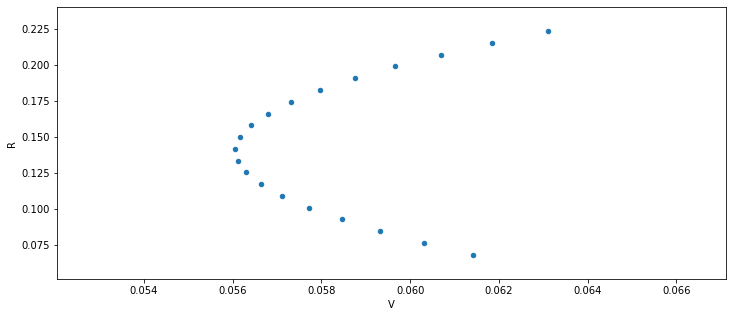

In [122]:
ef.plot.scatter(x="V", y="R" ,  figsize=(12,5))

We can create function that plots the frontier:

A useful summary of the visualization features in pandas is [here](https://pandas.pydata.org/pandasdocs/stable/user_guide/visualization.html)

In [173]:


def plot_ef2(n_points, er, cov , style="-."):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 :
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
        
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets    = [portfolio_return(w, er) for w in weights]
    vols    = [portfolio_vol(w, cov) for w in weights]
    ef      = pd.DataFrame({ "Returns": rets, "Volatility": vols })
    
    return ef.plot.line(x="Volatility", y="Returns", style= style , figsize=(12,5))

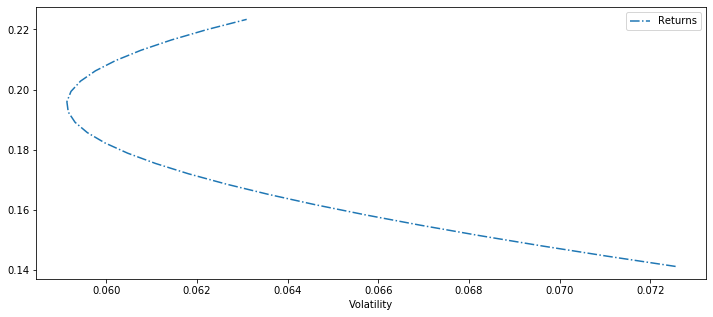

In [131]:
l = ['Stock_29', "Stock_02" ]
plot_ef2(25, er[l].values, cov_df.loc[l,l])

.

# Efficient Frontier - Part III - Running the Optimizer

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:
But let's start by loading up the data as usual:

In [163]:
ind = get_ind_returns()
er  = annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Stock_29" and "Stock_02". Let's plot that efficient frontier as we did last time:

```python 
scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)```

Parameters 

fun: the function that you want to minimize  (The objective function to be minimized) 

fun(x, *args) -> float


where x (initial values for the weight) is an 1-D array with shape (n,) and args is a tuple of the fixed parameters needed to completely specify the function.  

x0 ndarray, shape (n,)  
Initial guess. Array of real elements of size (n,), where ‘n’ is the number of independent variables.  

args: tuple, optional  
Extra arguments passed to the objective function and its derivatives (fun, jac and hess functions).  





In [178]:
# eq means equal 
# arg means addtional argument 
# fun means function 

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x 

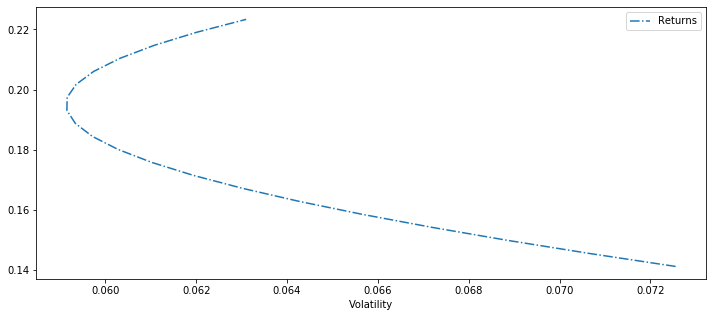

In [167]:
l = ['Stock_29', "Stock_02" ]
plot_ef2(20, er[l], cov.loc[l,l])

The Efficient Frontier for the protfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [168]:
weights_15 = minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15     = portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.06878027296869563

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

In [176]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-' , figsize=(12,5) )

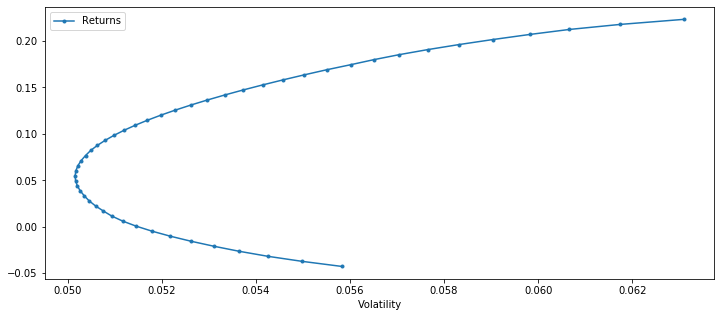

In [177]:
l = ['Stock_29', "Stock_02" , 'Stock_15', "Stock_10" ]
plot_ef(50, er[l], cov.loc[l,l])